In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent
from RLTrade.utils import (
    stationaryDGP, 
    nonstationaryDGP, 
    build_features, 
    build_rolling_feature,
    rolling_mean_correction
)

In [14]:
x, y = nonstationaryDGP()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread

In [15]:
# confirm the x, y pair is not cointegrated
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     6882.
Date:                Tue, 04 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:28:20   Log-Likelihood:                -23964.
No. Observations:               10000   AIC:                         4.793e+04
Df Residuals:                    9998   BIC:                         4.795e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.7535      0.179    561.830      0.0

In [16]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -1.5378970561171517
p-value: 0.5146879143404381
Is the spread stationary? No


In [20]:
df = rolling_mean_correction(df, window=200)
df

,x,y,close,rolling_mean_corrected_close
0,9.962294,110.045110,100.082817,0.000000
1,9.919568,110.106072,100.186503,0.051843
2,9.919966,110.132415,100.212449,0.051859
3,9.937903,110.173152,100.235249,0.055995
4,9.952898,110.157098,100.204201,0.019957
...,...,...,...,...
9995,8.228407,105.767430,97.539024,-3.065639
9996,8.219383,105.810876,97.591492,-2.993467
9997,8.255360,105.622425,97.367065,-3.197852
9998,8.162406,105.491452,97.329047,-3.215485


In [21]:
adfuller_test = adfuller(df["rolling_mean_corrected_close"])
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -5.64985404855203
p-value: 9.917871268889067e-07
Is the spread stationary? Yes


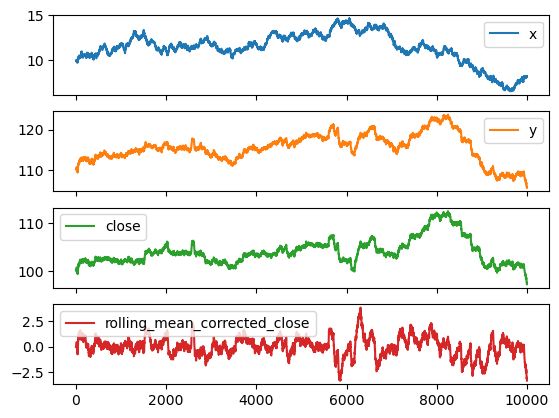

In [22]:
df.plot(subplots=True)
plt.show()

In [23]:
# build features
df_train = df.copy()

feature_config = {
    "feature_col": "rolling_mean_corrected_close",
    "window": 7, # 7 days window, pad with first value when window is not available
    "mode": "diff" # difference between current and previous close price
}

df_train = build_rolling_feature(df_train, **feature_config)
df_train

,x,y,close,rolling_mean_corrected_close,feature_rolling_0,feature_rolling_1,feature_rolling_2,feature_rolling_3,feature_rolling_4,feature_rolling_5,feature_rolling_6
0,9.962294,110.045110,100.082817,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.919568,110.106072,100.186503,0.051843,0.051843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,9.919966,110.132415,100.212449,0.051859,0.000016,0.051843,0.000000,0.000000,0.000000,0.000000,0.000000
3,9.937903,110.173152,100.235249,0.055995,0.004135,0.000016,0.051843,0.000000,0.000000,0.000000,0.000000
4,9.952898,110.157098,100.204201,0.019957,-0.036038,0.004135,0.000016,0.051843,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
9995,8.228407,105.767430,97.539024,-3.065639,-0.079048,0.091569,-0.197910,-0.030859,-0.123822,-0.131263,-0.108831
9996,8.219383,105.810876,97.591492,-2.993467,0.072171,-0.079048,0.091569,-0.197910,-0.030859,-0.123822,-0.131263
9997,8.255360,105.622425,97.367065,-3.197852,-0.204385,0.072171,-0.079048,0.091569,-0.197910,-0.030859,-0.123822
9998,8.162406,105.491452,97.329047,-3.215485,-0.017633,-0.204385,0.072171,-0.079048,0.091569,-0.197910,-0.030859


In [24]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

[ 0.  0.  0.  0.  0.  0.  0. -1. -1.]
Market Return : -2.85%   |   Portfolio Return :  2.85%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [25]:
# Train a DQN agent using training data from a stationary data generating process
n_actions = env.action_space.n
n_observations = len(env.reset()[0])

agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -2.85%   |   Portfolio Return : -56.70%   |   Position Changes : 5627   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -38.32%   |   Position Changes : 4996   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -34.86%   |   Position Changes : 4977   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -31.52%   |   Position Changes : 4878   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -21.81%   |   Position Changes : 4757   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -27.63%   |   Position Changes : 4757   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -25.97%   |   Position Changes : 4741   |   Episode Length : 10000   |   
Market Return : -2.85%   |   Portfolio Return : -32.03%   |   Position Changes : 4614   |   Episode Length : 10000   |   
Market Return : -2.85%  

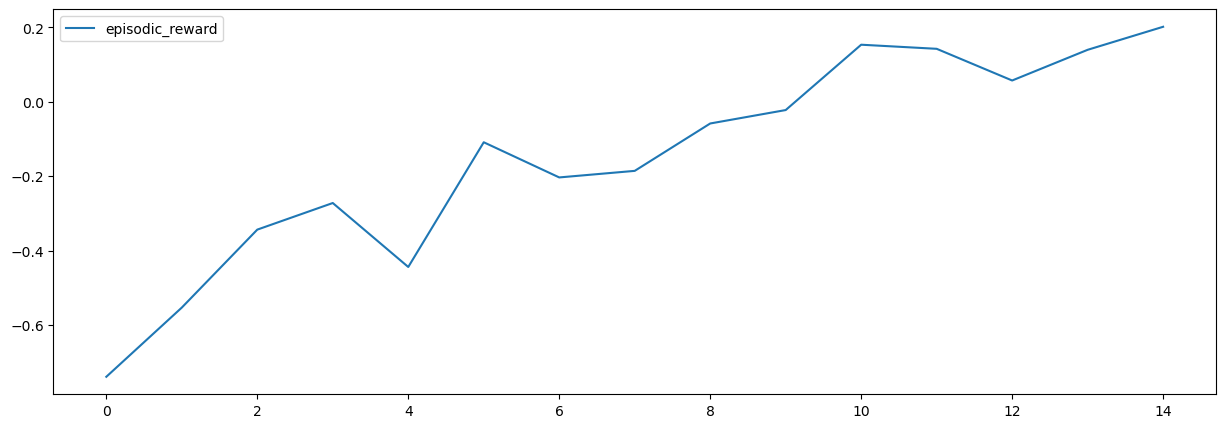

In [11]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [26]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationaryDGP()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    _df = rolling_mean_correction(_df, window=200)
    _df = build_rolling_feature(_df, **feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -7.68%   |   Portfolio Return : -41.18%   |   Position Changes : 5802   |   Episode Length : 10000   |   
Market Return : 23.26%   |   Portfolio Return : -45.97%   |   Position Changes : 5674   |   Episode Length : 10000   |   
Market Return : -1.47%   |   Portfolio Return : -52.44%   |   Position Changes : 5654   |   Episode Length : 10000   |   
Market Return : -14.99%   |   Portfolio Return : -49.14%   |   Position Changes : 5705   |   Episode Length : 10000   |   
Market Return : -24.68%   |   Portfolio Return : -45.85%   |   Position Changes : 5706   |   Episode Length : 10000   |   
Market Return :  7.60%   |   Portfolio Return : -48.02%   |   Position Changes : 5760   |   Episode Length : 10000   |   
Market Return : -2.41%   |   Portfolio Return : -53.51%   |   Position Changes : 5736   |   Episode Length : 10000   |   
Market Return : -0.63%   |   Portfolio Return : -53.13%   |   Position Changes : 5675   |   Episode Length : 10000   |   
Market Return : -8.84%